In [1]:
import numpy as np
import pandas as pd
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly_express as px
import plotly.graph_objects as go

import seaborn as sns

In [2]:
for dirname, _, filenames in os.walk('./Mercari price suggestion/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Mercari price suggestion/test.tsv.7z
./Mercari price suggestion/test_desc.csv
./Mercari price suggestion/train.tsv.7z
./Mercari price suggestion/train_desc.csv
./Mercari price suggestion/test\test.tsv
./Mercari price suggestion/train\train.tsv


In [3]:
# Train data
train = pd.read_csv('./Mercari price suggestion/train/train.tsv', sep='\t')
test = pd.read_csv('./Mercari price suggestion/test/test.tsv', sep='\t')


display(train.head())
print('Train data:', train.shape)
#display(train.shape)

print('Test data shape: ', test.shape)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


Train data: (1482535, 8)
Test data shape:  (693359, 7)


In [4]:
train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


### Check for missing values ###

In [6]:
train.isnull().sum()[train.isnull().sum().values > 0]

category_name         6327
brand_name          632682
item_description         4
dtype: int64

### Target variable - 'price'

In [7]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

### Target variable - 'price' - distribution
* Log transformation to change to normal distribution

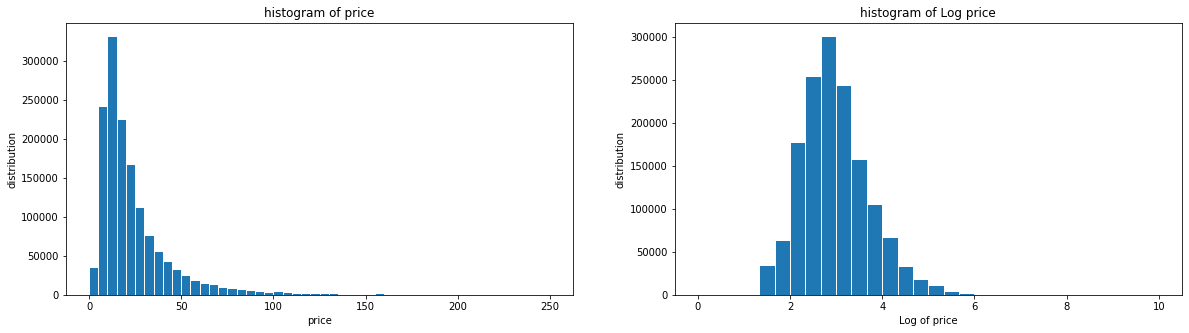

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.hist(train['price'], range=[0,250], bins=50, edgecolor='w')
ax1.set_xlabel('price')
ax1.set_ylabel('distribution')
ax1.set_title('histogram of price')

ax2.hist(np.log1p(train['price']), range=[0,10], bins=30, edgecolor='w')
ax2.set_xlabel('Log of price')
ax2.set_ylabel('distribution')
ax2.set_title('histogram of Log price')
plt.show()

In [9]:
train['logprice'] = np.log1p(train['price'])
train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,logprice
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662


### * Shipping variable *
- 'shipping':
    - 1 if shipping fee is paid by seller
    - 0 if shipping fee is paid by buyer
    
- 'Shipping fee' is quite evenly split  between the buyer and seller
    - 55% of shipping fee is paid by the buyer

In [10]:
train['shipping'].value_counts(normalize=True)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

### Check for any relationship between shipping fee and price
- the price of good is slightly lesser when the seller pays for the shipping to make the price competitive

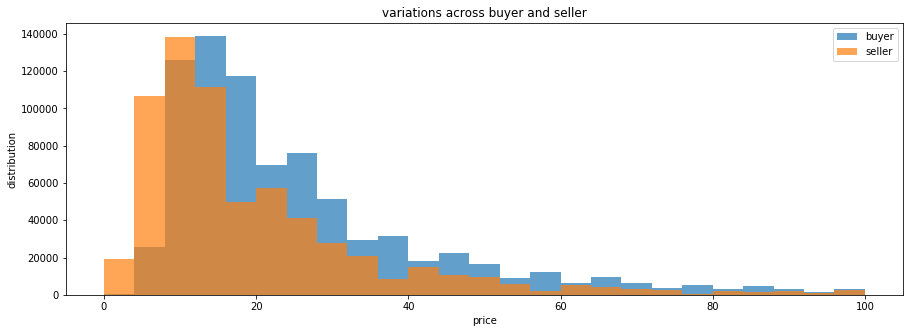

In [11]:
plt.figure(figsize=(15,5))
train.groupby('shipping')['price'].plot(kind='hist', range=[0,100], bins=25, alpha=0.7)
plt.legend(labels=['buyer', 'seller'])
plt.xlabel('price')
plt.ylabel('distribution')
plt.title('variations across buyer and seller')
plt.show()

### * Category types *

In [12]:
print('Number of unique categories is: {}\n'.format(len(train['category_name'].value_counts())))
print('Top 10 categories: \n{}'.format(train['category_name'].value_counts()[:10]))

Number of unique categories is: 1287

Top 10 categories: 
Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Tank, Cami                                20284
Women/Tops & Blouses/Blouse                                    20284
Name: category_name, dtype: int64


In [13]:
# split the categories

# text = 'Women/Athletic Apparel/Pants, Tights, Leggings'
# text.split('/')

def split_categories(text):
    try:
        return text.split('/')
    # if no category name
    except: 
        return ['no label', 'no label', 'no label']

In [14]:
train['general_cat'] = train['category_name'].apply(lambda x: split_categories(x)[0])
train['sub_cat1'] = train['category_name'].apply(lambda x: split_categories(x)[1])
train['sub_cat2'] = train['category_name'].apply(lambda x: split_categories(x)[2])

train.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,logprice,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma...",4.094345,Women,Other,Other
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...,4.174387,Women,Swimwear,Two-Piece
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...,1.945910,Sports & Outdoors,Apparel,Girls
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.,2.995732,Sports & Outdoors,Apparel,Girls
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...,2.197225,Vintage & Collectibles,Collectibles,Doll


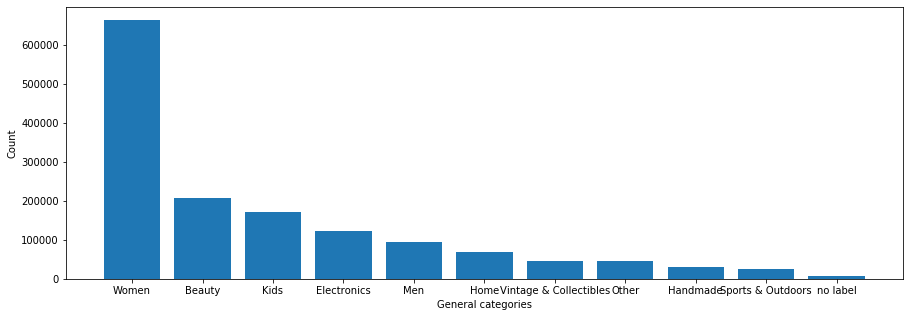

In [15]:
plt.figure(figsize=(15,5))
plt.bar(x = train['general_cat'].value_counts().index.values, height = train['general_cat'].value_counts().values)
plt.xlabel('General categories')
plt.ylabel('Count')
plt.show()

In [16]:
import gc
gc.collect()

9263

In [17]:
# show in plotly

trace = go.Bar(x = train['general_cat'].value_counts().index.values, 
               y = train['general_cat'].value_counts().values,
                text = round(train['general_cat'].value_counts(normalize=True)*100,2)
              )
layout = go.Layout(dict(
                        title = 'Number of items by general category'),
                        xaxis= dict(title = 'general categories'),
                        yaxis= dict(title = 'Count')
                  )
fig  = go.Figure(data =trace, layout = layout)
#py.iplot(fig)
fig.show()

### Sub category 1 - Top 20

In [18]:
# show in plotly

trace = go.Bar(x = train['sub_cat1'].value_counts().index.values[:20], 
               y = train['sub_cat1'].value_counts().values[:20],
                text = round(train['sub_cat1'].value_counts(normalize=True)*100,2)
              )
layout = go.Layout(dict(
                        title = 'Number of items by sub_category 1'),
                        xaxis= dict(title = 'sub_category 1'),
                        yaxis= dict(title = 'Count')
                  )
fig  = go.Figure(data =trace, layout = layout)
#py.iplot(fig)
fig.show()

In [19]:
# show in plotly

trace = go.Bar(x = train['sub_cat2'].value_counts().index.values[:20], 
               y = train['sub_cat2'].value_counts().values[:20],
                text = round(train['sub_cat2'].value_counts(normalize=True)*100,2),
                             )
layout = go.Layout(dict(
                        title = 'Number of items by sub_category 2'),
                        xaxis= dict(title = 'sub_category 2'),
                        yaxis= dict(title = 'Count'),
                        )
fig  = go.Figure(data =trace, layout = layout)
py.iplot(fig)

In [ ]:
gen_cat = train['general_cat'].unique()
x = [train.loc[train['general_cat'] == cat, 'price'] for cat in gen_cat]

trace = [go.Box(x = np.log1p(x[i]), name = gen_cat[i]) for i in range(len(gen_cat))]
layout = dict(
            title = 'Price distrbution across general category',
            xaxis = dict(title='distribution'),
            yaxis = dict(title = 'category')
            )
fig = go.Figure(data = trace, layout=layout)
#py.iplot(fig)
fig.show()

In [ ]:
train.isnull().sum()[train.isnull().sum().values > 0]

In [ ]:
# fill the columns that have missing values

def handle_missing_values(df):
    df['category_name'].fillna(value = 'missing', inplace=True)
    df['brand_name'].fillna(value = 'missing', inplace=True)
    df['item_description'].replace('No description yet', 'missing', inplace=True)
    df['item_description'].fillna(value = 'missing', inplace=True)

### **Brand names**

In [ ]:
print('Number of unique brands is : ', len(train['brand_name'].value_counts()))
print('Number of unique brands with count > 1 : ', len(train['brand_name'].value_counts()[train['brand_name'].value_counts() > 1]))

### Item description
- the data is very unstructured
- has punctuations, numbers etc which need to be removed
- remove stop words
- also remove any words with len < 3

In [ ]:
train['item_description']

In [ ]:
text = train.iloc[1482534]['item_description']
text

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [ ]:
import re

def tokenize_text(text):
    regex = re.compile(r'[a-zA-Z]{3,}')
    txt = regex.findall(str(text).lower())
    #tokens = [t for t in txt if t not in stop and len(t)>3]
    tokens = [t for t in txt if t not in stop and len(t)>3]
    return tokens

### get count of tokens

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer
# #cv = CountVectorizer(stop_words='english', token_pattern= r'\b[^\d\W]+\b')
# cv = CountVectorizer(stop_words='english', token_pattern= r'[a-zA-Z]{3,}')
# #cv = CountVectorizer()

# def word_count(text):
#     try:
#         cv.fit([text]) ## if this doesnt work, try 'text' instead of '[text]'
#         return len(cv.get_feature_names())
#     except:
#         return 0

### get tokens

In [ ]:
#cv = CountVectorizer(stop_words='english', token_pattern= r'\b[^\d\W]+\b')
# cv = CountVectorizer(stop_words='english', token_pattern= r'[a-zA-Z]{3,}')
# #cv = CountVectorizer(stop_words='english')

# def word_token(text):
#     try:
#         cv.fit([text]) ## if this doesnt work, try 'text' instead of '[text]'
#         tokens = cv.get_feature_names()
#         return tokens
#     except:
#         return 0

### Looking at a sample of the full dataset

In [ ]:
# trace = go.Scatter(x = df['desc_length'], y = df['price'],
#                   mode = 'lines+markers')
# layout = go.Layout(dict(title='price vz description'))

# fig = go.Figure(data=[trace], layout=layout)
# fig.show()

### Taking the complete train dataset

### test a sample

In [ ]:
train_sample = train.sample(frac=0.001, random_state=123)
train_sample['tokens'] = train_sample['item_description'].apply(lambda x: tokenize_text(x))
train_sample['desc_length'] = train_sample['tokens'].apply(lambda x: len(x))

train_sample.head(10)

for description, tokens, length in zip(train_sample['item_description'], train_sample['tokens'], train_sample['desc_length']):
    print('Item description: ', description)
    print('Word tokens', tokens)
    print('Description length: ', length)
    print('\n')

### Taking the complete train dataset

In [ ]:
# train['tokens'] = train['item_description'].apply(lambda x: tokenize_text(x))
# train['desc_length'] = train['tokens'].apply(lambda x: len(x))

# train.head(10)

# for description, tokens, length in zip(train_sample['item_description'], train_sample['tokens'], train_sample['desc_length']):
#     print('Item description: ', description)
#     print('Word tokens', tokens)
#     print('Description length: ', length)
#     print('\n')

In [ ]:
# train_sample = train.sample(frac=0.001, random_state=10)
# train_sample['tokens'] = train_sample['item_description'].apply(lambda x: tokenize_text([x]))
# train_sample['desc_length'] = train_sample['item_description'].apply(lambda x: word_count([x]))
# train_sample[['tokens','desc_length']].head(10)

In [ ]:
import datetime
import time

start = time.time()
print('Start time:', datetime.datetime.now().strftime("%Y-%m-%d %H:%M"))
train['tokens'] = train['item_description'].apply(lambda x: tokenize_text(x))
train['desc_length'] = train['tokens'].apply(lambda x: len(x))

print('time taken for train:', time.time() - start)
print('End time:', datetime.datetime.now().strftime("%Y-%m-%d %H:%M"))

# for test
start = time.time()
print('Start time:', datetime.datetime.now().strftime("%Y-%m-%d %H:%M"))
test['tokens'] = test['item_description'].apply(lambda x: tokenize_text(x))
test['desc_length'] = test['tokens'].apply(lambda x: len(x))
print('time taken for test:', time.time() - start)
# print('End time:', datetime.datetime.now().strftime("%Y-%m-%d %H:%M"))


In [ ]:
train.head(10)

### Saving the file into a new csv file

In [ ]:
train.to_csv('train_desc.csv',index=False)
test.to_csv('test_desc.csv',index=False)

In [ ]:
# train = pd.read_csv('/kaggle/input/mercari-price-suggestion-with-desc/train_desc.csv')
# test = pd.read_csv('/kaggle/input/mercari-price-suggestion-with-desc/test_desc.csv')
# train.head()

### * Mean price for description length *

In [ ]:
df = train.groupby('desc_length')['price'].mean().reset_index()
df

In [ ]:
trace = go.Scatter(
                    x = df['desc_length'],
                    y = df['price'],
                    mode = 'lines+markers',
                    )

layout = go.Layout(dict(title = 'Average price per description length',
                       xaxis = dict(title = 'Description length'),
                       yaxis = dict(title = 'price')
                       )
                  )
fig = go.Figure(data = [trace], layout=layout)
py.iplot(fig)

In [ ]:
display(train.isnull().sum())
display(train.shape)

In [ ]:
# removing the entries which do not have a 'item description'

train_new = train[pd.notnull(train['item_description'])]
display(train_new.isnull().sum())
display(train_new.shape)

### General categories

In [ ]:
train['general_cat'].value_counts()

### Create a 'WordCloud' for the most common words in each 'general' category

In [ ]:
from wordcloud import WordCloud
from collections import Counter

cat_desc = dict()
for cat in train_sample['general_cat'].value_counts().index.tolist():
    text = " ".join(train_sample.loc[train_sample['general_cat'] == cat, 'item_description'].values)
    cat_desc[cat]= tokenize_text(text)

womens100 = Counter(cat_desc['Women']).most_common(100)
beauty100 = Counter(cat_desc['Beauty']).most_common(100)
kids100 = Counter(cat_desc['Kids']).most_common(100)
electronics100 = Counter(cat_desc['Electronics']).most_common(100)

In [ ]:
keys = [k for (k,v) in womens100]
text = " ".join(keys)
text

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#optional - to remove the word 'shipping' from the wordcloud
stopwords = set(STOPWORDS)
#print(stopwords)
stopwords.update(['shipping', 'Shipping', "shipping'"])
#optional

def create_wordcloud(text):
    wordcloud = WordCloud(background_color='white', stopwords=stopwords,
                          max_font_size=30).generate(text)
    return wordcloud

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15, 10))

# wordcloud requires input text to be a string

ax[0,0].imshow(create_wordcloud(str(womens100)), interpolation='bilinear')
ax[0,0].set_title('women', fontsize=25)

ax[0,1].imshow(create_wordcloud(str(beauty100)), interpolation='bilinear')
ax[0,1].set_title('beauty', fontsize=25)

ax[1,0].imshow(create_wordcloud(str(kids100)), interpolation='bilinear')
ax[1,0].set_title('kids', fontsize=25)

ax[1,1].imshow(create_wordcloud(str(electronics100)), interpolation='bilinear')
ax[1,1].set_title('Electronics', fontsize=25)

plt.tight_layout(pad =1)
plt.show()

In [ ]:
?WordCloud